## LinearRegression 클래스 - Ordinary Least Squares

#### 입력 파라미터
- fit_intercept: 불린 값으로, 디폴트는 True. Intercept(절편) 값을 계산할 것인지 말지를 지정. False이면 intercept가 사용되지 않고 0으로 지정.
- normalize: 불린 값으로 디폴트는 False. False이면 무시되고, True이면 회귀를 수행하기 전에 입력 데이터 세트를 정규화 함.
#### 속성
- coef_: fit() 메서드를 수행했을 때 회귀 계수가 배열 형태로 저장하는 속성. Shape는 (Target 값 개수, 피처 개수).
- intercept_: intercept 값


### 다중 공선성(Multi-collinearity) 문제
Ordinary Least Squares 기반의 회귀 계수 계산은 입력 피처의 독립성에 많은 영향을 받음. 피처 간의 상관관계가 매우 높은 경우 분산이 매우 커져서 오류에 매우 민감해진다.
상관관계가 높은 피처가 많은 경우 독립적인 중요한 피처만 남기고 제거하거나 규제를 적용. 매우 많은 피처가 다중 공선성 문제를 가지고 있다면 PCA를 통해 차원 축소를 수행하는 것도 고려해 볼 수 있음.

## 회귀 평가 지표

- MAE: Mean Absolute Error(MAE)이며 실제 값과 예측값의 차이를 절댓값으로 변환해 평균한 것. -> $MAE = \frac{1}{n}\sum_{i=1}^n|Yi-\hat{Y}i|$
- MSE: Mean Sqaured Error(MSE)이며 실제 값과 예측값의 차이를 제곱해 평균한 것. -> $MSE = \frac{1}{n}\sum_{i=1}^n(Yi-\hat{Y}i)^2$
- RMSE: MSE 값은 오류의 제곱을 구하므로 실제 오류 평균보다 더 커지는 특성이 있으므로 MSE에 루트를 씌운 것이 RMSE(Root Mean Squared Error). -> $MSE = \sqrt{\frac{1}{n}\sum_{i=1}^n(Yi-\hat{Y}i)^2}$
- $R^2$: 분산 기반 기반으로 예측 성능을 평가. 실제 값의 분산 대비 예측값의 분산 비율을 지표로 함, 1에 가까울수록 예측 정확도가 높음. -> $\frac{예측값 Variance}{실제값 Variance}$

| 평가 방법 | 사이킷런 평가 지표 API      | Scoring 함수 적용 값      |
|:----------|:-----------------------------|:---------------------------|
| MAE      | metrics.mean_absolute_error | 'neg_mean_absolute_error' |
| MSE      | metrics.mean_squared_error  | 'neg_mean_squared_error'  |
| $R^2$    | metrics.r2_score            | 'r2'                      |

## LinearRegression을 이용해 보스턴 주택 가격 회귀 구현

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

# boston 데이터 세트 로드
boston = load_boston()

# boston 데이터 세트 DataFrame 반환
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

# boston 데이터 세트의 target 배열은 주택 가격임. 이를 PRICE 칼럼으로 DataFrame에 추가함.
bostonDF['PRICE'] = boston.target
print('Boston 데이터 세트 크기:', bostonDF.shape)
bostonDF.head()

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

Boston 데이터 세트 크기: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


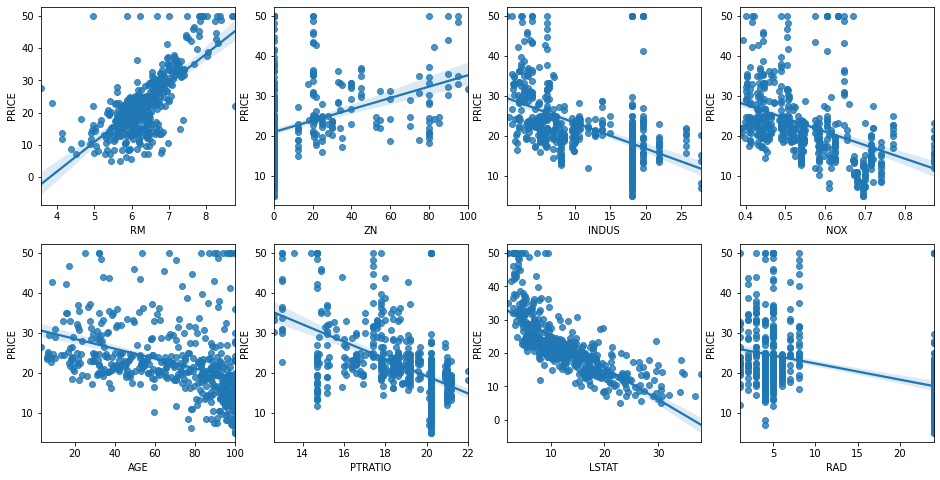

In [4]:
# 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4x2개의 ax를 가짐.
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
lm_features = ['RM', 'ZN', 'INDUS', 'NOX', 'AGE', 'PTRATIO', 'LSTAT', 'RAD']
for i, feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

# 선형 회귀 OLS로 학습/예측/평가 수행.
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3F}'.format(mse, rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297, RMSE : 4.159
Variance score : 0.757


In [6]:
print('절편 값:', lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_, 1))

절편 값: 40.995595172164755
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [7]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. 인덱스 칼럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_, 1), index=X_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
B           0.0
TAX        -0.0
AGE         0.0
INDUS       0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [8]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)
lr = LinearRegression()

# cross_val_score()로 5 폴드 세트로 MSE를 구한 뒤 이를 기반으로 다시 RMSE 구함.
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring="neg_mean_squared_error")로 반환된 값은 모두 음수
print(' 5 folds 의 개별 Negative MSE scores : ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores :  [-12.46 -26.05 -33.07 -80.76 -33.31]
 5 folds 의 개별 RMSE scores :  [3.53 5.1  5.75 8.99 5.77]
 5 folds 의 평균 RMSE : 5.829 
